In [2]:
from scipy.optimize import minimize
import numpy as np

def logistic_prob(X, w):
    """ MAP (Bayes point) logistic regression probability with overflow prevention via exponent truncation

    Parameters
    ----------
    X : array-like, shape (N, p)
        Feature matrix
    w : array-like, shape (p, )
        Parameter vector

    Returns
    -------

    pr : array-like, shape (N, )
        vector of logistic regression probabilities

    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)

    """

    # set a truncation exponent.
    trunc = 8.  # exp(8)/(1+exp(8)) = 0.9997 which is close enough to 1 as to not matter in most cases.

    # calculate argument of logit
    z = np.dot(X, w)

    # truncate to avoid numerical over/underflow
    z = np.clip(z, -trunc, trunc)

    # calculate logitstic probability
    pr = np.exp(z)
    pr = pr / (1. + pr)

    return pr



def f_log_posterior(w, wprior, H, y, X, weights=None):
    """Returns negative log posterior probability.

    Parameters
    ----------
    w : array-like, shape (p, )
        vector of parameters at which the negative log posterior is to be evaluated
    wprior : array-like, shape (p, )
        vector of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        Array of prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        vector of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        vector of data point weights. Should be within [0,1]

    Returns
    -------
    neg_log_post : float
                negative log posterior probability

    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)

    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # calculate negative log posterior

    eps = 1e-6  # this defined to ensure that we never take a log of zero

    mu = logistic_prob(X, w)

    if len(H.shape) == 2:
        neg_log_post = (- (np.dot(y.T, weights * np.log(mu + eps))
                           + np.dot((1. - y).T, weights * np.log(1. - mu + eps)))
                        + 0.5 * np.dot((w - wprior).T, np.dot(H, (w - wprior))))
    elif len(H.shape) == 1:
        neg_log_post = (- (np.dot(y.T, weights * np.log(mu + eps))
                           + np.dot((1. - y).T, weights * np.log(1. - mu + eps)))
                        + 0.5 * np.dot((w - wprior).T, H * (w - wprior)))
    else:
        raise ValueError('Incompatible Hessian')

    return float(neg_log_post)

def g_log_posterior(w, wprior, H, y, X, weights=None):
    """Returns gradient of the negative log posterior probability.

    Parameters
    ----------
    w : array-like, shape (p, )
        parameter vector at which the gradient is to be evaluated
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        array of prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        array of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]

    Returns
    -------
    grad_log_post : array-like, shape (p, )
                gradient of negative log posterior

    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)

    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # calculate gradient

    mu_ = logistic_prob(X, w)

    if len(H.shape) == 2:
        grad_log_post = np.dot(X.T, weights * (mu_ - y)) + np.dot(H, (w - wprior))
    elif len(H.shape) == 1:
        grad_log_post = np.dot(X.T, weights * (mu_ - y)) + H * (w - wprior)
    else:
        raise ValueError('Incompatible Hessian')

    return grad_log_post


def HP_log_posterior(w, q, wprior, H, y, X, weights=None):
    """Returns diagonal Hessian of the negative log posterior probability multiplied by an arbitrary vector.
    This is useful for the Newton-CG solver, particularly when we only want to store a diagonal Hessian.

    Parameters
    ----------
    w : array-like, shape (p, )
        parameter vector at which the Hessian is to be evaluated
    q : array-like, shape (p, )
        arbitrary vector to multiply Hessian by
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, )
        array of diagonal log prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        array of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]

    Returns
    -------
    HP : array-like, shape (p, )
        Hessian of log posterior (diagonal approx) multiplied by arbitrary vector

    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)

    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    HP = H_log_posterior(w, wprior, H, y, X, weights)
    HP = HP * q

    return HP

def H_log_posterior(w, wprior, H, y, X, weights=None):
    """Returns Hessian (either full or diagonal) of the negative log posterior probability.

    Parameters
    ----------
    w : array-like, shape (p, )
        parameter vector at which the Hessian is to be evaluated
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        array of log prior Hessian (inverse covariance of prior distribution of parameters)
    y : array-like, shape (N, )
        array of binary ({0,1} responses)
    X : array-like, shape (N, p)
        array of features
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]

    Returns
    -------
    H_log_post : array-like, shape like `H`
                Hessian of negative log posterior

    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)

    """

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # calculate log posterior Hessian

    mu = logistic_prob(X, w)

    S = mu * (1. - mu) * weights

    if len(H.shape) == 2:
        H_log_post = np.dot(X.T, X * S[:, np.newaxis]) + H
    elif len(H.shape) == 1:
        H_log_post = np.diag(np.dot(X.T, X * S[:, np.newaxis])) + H
    else:
        raise ValueError('Incompatible Hessian')

    return H_log_post

def fit_bayes_logistic(y, X, wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=100):
    """ Bayesian Logistic Regression Solver.  Assumes Laplace (Gaussian) Approximation
    to the posterior of the fitted parameter vector. Uses scipy.optimize.minimize

    Parameters
    ----------
    y : array-like, shape (N, )
        array of binary {0,1} responses
    X : array-like, shape (N, p)
        array of features
    wprior : array-like, shape (p, )
        array of prior means on the parameters to be fit
    H : array-like, shape (p, p) or (p, )
        array of prior Hessian (inverse covariance of prior distribution of parameters)
    weights : array-like, shape (N, )
        array of data point weights. Should be within [0,1]
    solver : string
        scipy optimize solver used.  this should be either 'Newton-CG', 'BFGS' or 'L-BFGS-B'.
        The default is Newton-CG.
    bounds : iterable of length p
        a length p list (or tuple) of tuples each of length 2.
        This is only used if the solver is set to 'L-BFGS-B'. In that case, a tuple
        (lower_bound, upper_bound), both floats, is defined for each parameter.  See the
        scipy.optimize.minimize docs for further information.
    maxiter : int
        maximum number of iterations for scipy.optimize.minimize solver.

    Returns
    -------
    w_fit : array-like, shape (p, )
        posterior parameters (MAP estimate)
    H_fit : array-like, shape like `H`
        posterior Hessian  (Hessian of negative log posterior evaluated at MAP parameters)

    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)

    """

    # Check that dimensionality of inputs agrees

    # check X
    if len(X.shape) != 2:
        raise ValueError('X must be a N*p matrix')
    (nX, pX) = X.shape

    # check y
    if len(y.shape) > 1:
        raise ValueError('y must be a vector of shape (p, )')
    if len(np.atleast_1d(y)) != nX:
        raise ValueError('y and X do not have the same number of rows')

    # check wprior
    if len(wprior.shape) > 1:
        raise ValueError('prior should be a vector of shape (p, )')
    if len(np.atleast_1d(wprior)) != pX:
        raise ValueError('prior mean has incompatible length')

    # check H
    if len(H.shape) == 1:
        if np.atleast_1d(H).shape[0] != pX:
            raise ValueError('prior Hessian is diagonal but has incompatible length')
    elif len(H.shape) == 2:
        (h1,h2) = np.atleast_2d(H).shape
        if h1 != h2:
            raise ValueError('prior Hessian must either be a p*p square matrix or a vector or shape (p, ) ')
        if h1 != pX:
            raise ValueError('prior Hessian is square but has incompatible size')

    # fill in weights if need be
    if weights is None:
        weights = np.ones(len(np.atleast_1d(y)), )
    if len(np.atleast_1d(weights)) != len(np.atleast_1d(y)):
        raise ValueError(' weight vector must be same length as response vector')

    # Do the regression

    if solver == 'Newton-CG':

        if len(H.shape) == 2:

            ww = minimize(f_log_posterior, wprior, args=(wprior, H, y, X, weights), jac=g_log_posterior,
                          hess=H_log_posterior, method='Newton-CG', options={'maxiter': maxiter})
            w_fit = ww.x
            H_fit = H_log_posterior(w_fit, wprior, H, y, X, weights)

        elif len(H.shape) == 1:

            ww = minimize(f_log_posterior, wprior, args=(wprior, H, y, X, weights), jac=g_log_posterior,
                          hessp=HP_log_posterior, method='Newton-CG', options={'maxiter': maxiter})
            w_fit = ww.x
            H_fit = H_log_posterior(w_fit, wprior, H, y, X, weights)

        else:
            raise ValueError(' You must either use the full Hessian or its diagonal as a vector')

    return w_fit, H_fit

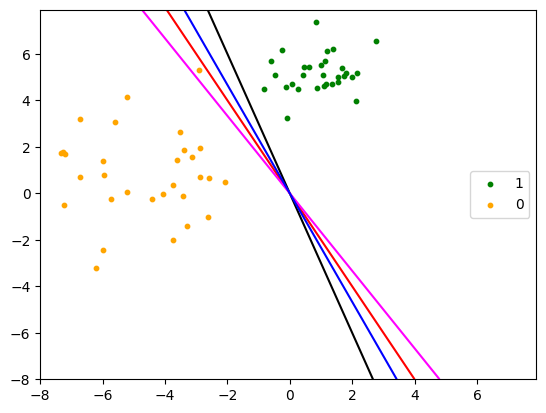

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

np.random.seed(135)

# Creating data
N = 30
D = 2
mu1 = np.hstack((np.ones((N, 1)), 5 * np.ones((N, 1))))
mu2 = np.hstack((-5 * np.ones((N, 1)), np.ones((N, 1))))
class1_std = 1
class2_std = 1.1
X_1 = np.add(class1_std * np.random.randn(N, 2), mu1)
X_2 = np.add(2 * class2_std * np.random.randn(N, 2), mu2)
X = np.vstack((X_1, X_2))
t = np.vstack((np.ones((N, 1)), np.zeros((N, 1))))

# Plotting data
x_1, y_1 = X[np.where(t == 1)[0]].T
x_2, y_2 = X[np.where(t == 0)[0]].T
plt.figure(0)
plt.scatter(x_1, y_1, c="green", s=10, marker="o", label=1)
plt.scatter(x_2, y_2, c="orange", s=10, marker="o", label=0)
plt.legend(loc="center right")

# Plotting Predictions
alpha = 100
Range = 8
step = 0.1
xx, yy = np.meshgrid(np.arange(-Range, Range, step), np.arange(-Range, Range, step))
[n, n] = xx.shape
W = np.hstack((xx.reshape((n * n, 1)), yy.reshape((n * n, 1))))
Xgrid = W
ws = np.array([[3, 1], [4, 2], [5, 3], [7, 3]])
col = ["black", "red", "magenta", "blue"]
for ii in range(ws.shape[0]):
    w = ws[ii][:]
    pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, w)))
    plt.contour(xx, yy, pred.reshape((n, n)), 1, colors=col[ii])
# plt.title("Data")
# pml.savefig("logreg_laplace_data")
plt.show()

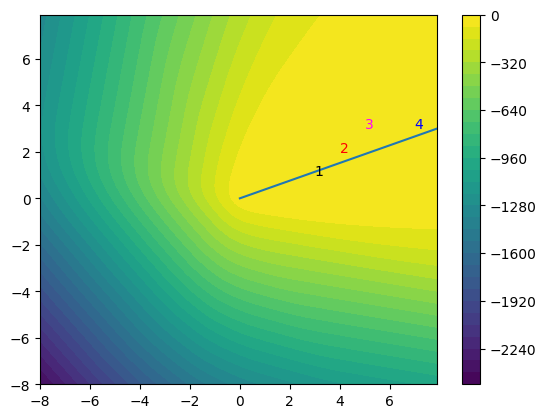

In [4]:
# Plot prior, likelihood, posterior

Xt = np.transpose(X)
f = np.dot(W, Xt)
log_prior = np.log(multivariate_normal.pdf(W, cov=(np.identity(D)) * alpha))
log_like = np.dot(np.dot(W, Xt), t) - np.sum(np.log(1 + np.exp(f)), 1).reshape((n * n, 1))
log_joint = log_like.reshape((n * n, 1)) + log_prior.reshape((n * n, 1))

# Plotting log-prior
# plt.figure(1)
# plt.contour(xx, yy, -1*log_prior.reshape((n,n)), 30, cmap="magma")
# plt.title("Log-Prior")

plt.figure(1)
ctr = plt.contourf(
    xx,
    yy,
    log_like.reshape((n, n)),
    30,
)

# Plotting points corresponding to chosen lines
for ii in range(0, ws.shape[0]):
    w = np.transpose(ws[ii, :])
    plt.annotate(str(ii + 1), xy=(w[0], w[1]), color=col[ii])

j = np.argmax(log_like)
wmle = W[j, :]
slope = wmle[1] / wmle[0]
# plt.axline([wmle[0], wmle[1]], slope=slope)
plt.plot([0, 7.9], [0, 7.9 * slope])
plt.colorbar(ctr)
# plt.title("Log likelihood")
# pml.savefig("logreg_laplace_logLik")
plt.show()

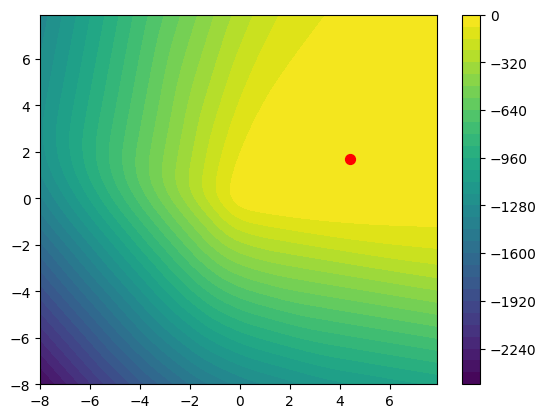

In [5]:
# Plotting the log posterior(Unnormalised)
plt.figure(2)
ctr = plt.contourf(xx, yy, log_joint.reshape((n, n)), 30, cmap="viridis")
j2 = np.argmax(log_joint)
wb = W[j2][:]
plt.scatter(wb[0], wb[1], c="red", s=50)
plt.colorbar(ctr)
# plt.title("Log-unnormalised posterior")
# pml.savefig("logreg_laplace_unnormalised_posterior")
plt.show()

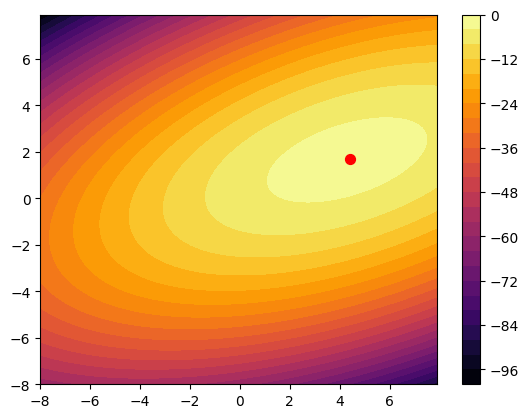

In [7]:
# Plotting the Laplace approximation to posterior
plt.figure(3)
# https://bayes-logistic.readthedocs.io/en/latest/usage.html
# Visit the website above to access the source code of bayes_logistic library
# parameter info : bayes_logistic.fit_bayes_logistic(y, X, wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=100)
wfit, hfit = fit_bayes_logistic(
    t.reshape((N * D)),
    X,
    np.zeros(D),
    ((np.identity(D)) * 1 / alpha),
    weights=None,
    solver="Newton-CG",
    bounds=None,
    maxiter=100,
)
co = np.linalg.inv(hfit)
# wfit represents the posterior parameters (MAP estimate)
# hfit represents the posterior Hessian  (Hessian of negative log posterior evaluated at MAP parameters)
log_laplace_posterior = np.log(multivariate_normal.pdf(W, mean=wfit, cov=co))
ctr = plt.contourf(xx, yy, log_laplace_posterior.reshape((n, n)), 30, cmap="inferno")
plt.scatter(wb[0], wb[1], c="red", s=50)
plt.colorbar(ctr)
# plt.title("Laplace approximation to posterior")
# pml.savefig("logreg_laplace_posterior")
plt.show()

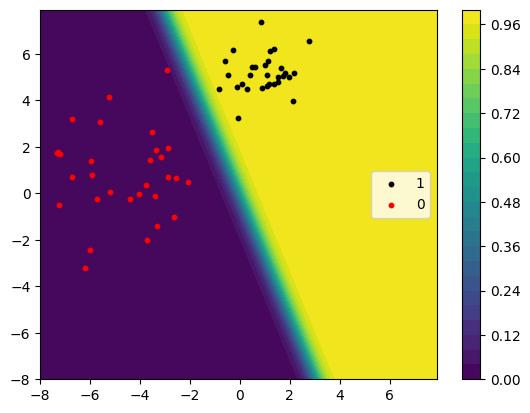

In [8]:
# Plotting the predictive distribution for logistic regression
plt.figure(5)
pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, wfit)))
ctr = plt.contourf(xx, yy, pred.reshape((n, n)), 30)
x_1, y_1 = X[np.where(t == 1)[0]].T
x_2, y_2 = X[np.where(t == 0)[0]].T
plt.scatter(x_1, y_1, c="black", s=10, marker="o", zorder=2.5, label="1")
plt.scatter(x_2, y_2, c="red", s=10, marker="o", zorder=2.5, label="0")
plt.legend(loc="right")
plt.colorbar(ctr)
# plt.title(r"$p(y=1|x, w_{MAP})$")
# pml.savefig("logreg_laplace_prediction_plugin")
plt.show()

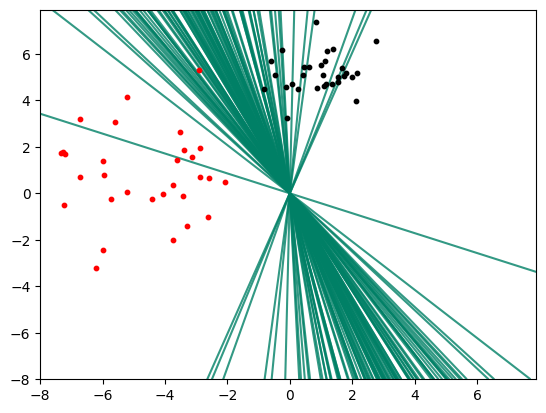

In [9]:
# Decision boundary for sampled w
plt.figure(6)
plt.scatter(x_1, y_1, c="black", s=10, marker="o", zorder=2.5)
plt.scatter(x_2, y_2, c="red", s=10, marker="o", zorder=2.5)
predm = np.zeros((n * n, 1))
s = 100
for i in range(s):
    wsamp = np.random.multivariate_normal(mean=wfit, cov=co)
    pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, wsamp)))
    predm = np.add(predm, pred.reshape((n * n, 1)))
    ctr = plt.contour(xx, yy, pred.reshape((n, n)), np.array([0.5]), cmap="summer", alpha=0.8)

# plt.title("Decision boundary for sampled w")
# pml.savefig("logreg_laplace_prediction_samples")
plt.show()

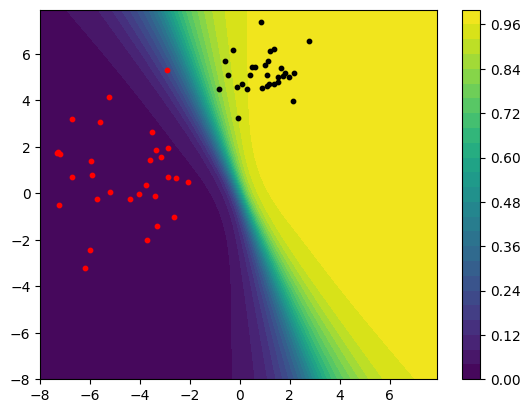

In [10]:
# MC
plt.figure(7)
predm = predm / s
ctr = plt.contourf(xx, yy, predm.reshape((n, n)), 30)
plt.scatter(x_1, y_1, c="black", s=10, marker="o", zorder=2.5)
plt.scatter(x_2, y_2, c="red", s=10, marker="o", zorder=2.5)
plt.colorbar(ctr)
# plt.title(r"MC approx of $p(y=1|x)$")
# pml.savefig("logreg_laplace_prediction_mc")
plt.show()

In [12]:
def bayes_logistic_prob(X, w, H):
    """ Posterior predictive logistic regression probability.  Uses probit approximation
        to the logistic regression sigmoid. Also has overflow prevention via exponent truncation.

    Parameters
    ----------
    X : array-like, shape (N, p)
        array of covariates
    w : array-like, shape (p, )
        array of fitted MAP parameters
    H : array-like, shape (p, p) or (p, )
        array of log posterior Hessian (covariance matrix of fitted MAP parameters)

    Returns
    -------
    pr : array-like, shape (N, )
        moderated (by full distribution) logistic probability

    References
    ----------
    Chapter 8 of Murphy, K. 'Machine Learning a Probabilistic Perspective', MIT Press (2012)
    Chapter 4 of Bishop, C. 'Pattern Recognition and Machine Learning', Springer (2006)

    """

    # set a truncation exponent
    trunc = 8.  # exp(8)/(1+exp(8)) = 0.9997 which is close enough to 1 as to not matter in most cases.

    # unmoderated argument of exponent
    z_a = np.dot(X, w)

    # find  the moderation
    if len(H.shape) == 2:
        H_inv_ = np.linalg.inv(H)
        sig2_a = np.sum(X * np.dot(H_inv_, X.T).T, axis=1)
    elif len(H.shape) == 1:
        H_inv_ = 1. / H
        sig2_a = np.sum(X * (H_inv_ * X), axis=1)
    else:
        raise ValueError(' You must either use the full Hessian or its diagonal as a vector')

    # get the moderation factor. Implicit in here is approximating the logistic sigmoid with
    # a probit by setting the probit and sigmoid slopes to be equal at the origin. This is where
    # the factor of pi/8 comes from.
    kappa_sig2_a = 1. / np.sqrt(1. + 0.125 * np.pi * sig2_a)

    # calculate the moderated argument of the logit
    z = z_a * kappa_sig2_a

    # do a truncation to prevent exp overflow
    z = np.clip(z, -trunc, trunc)

    # get the moderated logistic probability
    pr = np.exp(z)
    pr = pr / (1. + pr)

    return pr

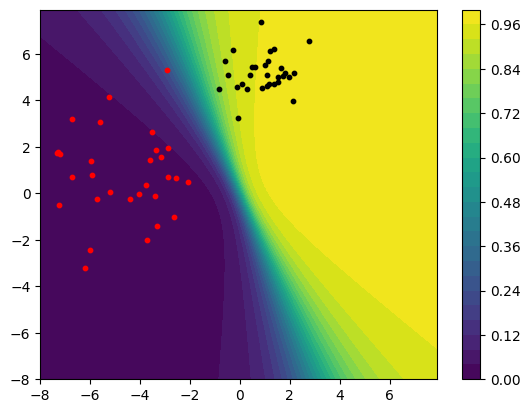

In [13]:
# Numerical
plt.figure(8)
plt.scatter(x_1, y_1, c="black", s=10, marker="o", zorder=2.5)
plt.scatter(x_2, y_2, c="red", s=10, marker="o", zorder=2.5)
pr = bayes_logistic_prob(Xgrid, wfit, hfit)
ctr = plt.contourf(xx, yy, pr.reshape((n, n)), 30)
plt.colorbar(ctr)
# plt.title(r"Deterministic approx of $p(y=1|x)$")
# pml.savefig("logreg_laplace_prediction_probit")
plt.show()